# Few warehouses take 3
Experiment with only a few warehouses but a lot of customers, which would be a more realistic scenario.


v1: first test, inconsistent results

v2: there was a bug in the DQN action analyzer

v3: Same as few warehouses v2 but with reproducibility setup, and donothing to track actions.
```
num_dcs = 3
num_customers = 100  #scale up to 200
num_commodities = 35  # scale up to 50
orders_per_day = int(num_customers * 0.05) #was going to be 0.1 but ran too slow.
# orders_per_day = 2
dcs_per_customer = 2
demand_mean = 500
demand_var = 150
num_steps = 30  # 1 month
num_episodes = 1000 #now with more eps ✨
```
big m cost: 100000

Commit: 52da3d40cf95fb6a6e24133005c31e4e0d12481d

In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina"
from pathlib import Path
import os
project_dir = Path(globals()['_dh'][0]+"/../python").resolve()
os.chdir(project_dir)
print("Running notebook from: " + os.path.abspath(""))

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr" # Default jupyter behavior
InteractiveShell.ast_node_interactivity = "all" # All expressions are shown.

Running notebook from: /Users/aleph/Documents/jota/tesis/ts_mcfrl/python


# Loading data

In [57]:
bestfit_consolidated_summary = pd.read_csv("data/results/bestfit_few_warehouses_v3/consolidated_summary.csv")
dumb_consolidated_summary = pd.read_csv("data/results/dumb_few_warehouses_v3/consolidated_summary.csv")
dqn2_consolidated_summary = pd.read_csv("data/results/dqn2_few_warehouses_v3/consolidated_summary.csv")
donothing_consolidated_summary = pd.read_csv("data/results/donotrhing_few_warehouses_v3/consolidated_summary.csv")
consolidated_summaries = [
    bestfit_consolidated_summary,
    dumb_consolidated_summary,
    dqn2_consolidated_summary,
    donothing_consolidated_summary
]
names = [
    'bestfit',
    'dumb',
    'dqn2',
    'donothing'
]

# Helper functions
Ideally get this from the code.

Whenever possible, use cost simplification factor of 1e9 for readability.

In [58]:
# visualization/shipping_allocation_result_viz.py
SIMPLIFICATION_FACTOR = 1e9
def calculate_costs_per_episode(consolidated_summary,cost_col='total_cost', simplification_factor=SIMPLIFICATION_FACTOR):
    costs_per_episode = consolidated_summary.groupby(["episode","experiment"])[cost_col].sum().reset_index().sort_values('episode')
    costs_per_episode[cost_col]= costs_per_episode[cost_col].astype("double")/simplification_factor
    return costs_per_episode

def compare_two_runs(consolidated_summary_a, consolidated_summary_b, simplification_factor=SIMPLIFICATION_FACTOR):
    # copy
    consolidated_summary_a = consolidated_summary_a.copy()
    consolidated_summary_b = consolidated_summary_b.copy()
    # simplify costs:
    consolidated_summary_b.total_cost = consolidated_summary_b.total_cost // simplification_factor
    consolidated_summary_b.total_cost = consolidated_summary_b.total_cost // simplification_factor

    # Analyzing mean & STD of cost per episode
    print(consolidated_summary_a.total_cost.describe())
    print(consolidated_summary_b.total_cost.describe())

# 1 - Comparing Costs between all runs

In [59]:
fig = plt.figure()

for i,c in enumerate(consolidated_summaries):
    c['experiment'] = names[i] 
all_summaries = pd.concat(consolidated_summaries,axis=0)

<Figure size 432x288 with 0 Axes>

In [60]:
all_summaries

,transportation_units,transportation_cost,inventory_units,inventory_cost,customer_units,customer_cost,total_cost,step,episode,experiment
0,33404,334040,0,0,0,0,334040,0,0,bestfit
1,46315,463150,0,0,0,0,463150,1,0,bestfit
2,231767,2317670,0,0,161230,116036500,118354170,2,0,bestfit
3,53326,533260,0,0,244775,34385150,34918410,3,0,bestfit
4,300737,3007370,0,0,395635,196199500,199206870,4,0,bestfit
...,...,...,...,...,...,...,...,...,...,...
28820,1031,10310,0,0,289240,113841700,113852010,22,999,donothing
28821,55485,554850,0,0,406620,4066200,4621050,23,999,donothing
28822,62443,624430,0,0,84885,42854550,43478980,24,999,donothing
28823,82010,820100,0,0,330895,139211200,140031300,25,999,donothing


In [61]:
cpe = calculate_costs_per_episode(all_summaries,cost_col='total_cost')
cpe

,episode,experiment,total_cost
0,0,bestfit,3.137198
1,0,donothing,2.939514
2,0,dqn2,2.194427
3,0,dumb,5.091714
4,1,bestfit,4.002248
...,...,...,...
3993,998,donothing,1.993994
3997,999,donothing,2.409929
3998,999,dqn2,1.979890
3996,999,bestfit,3.280709


Text(0.5, 1.0, 'Total cost across episodes (in millions)')

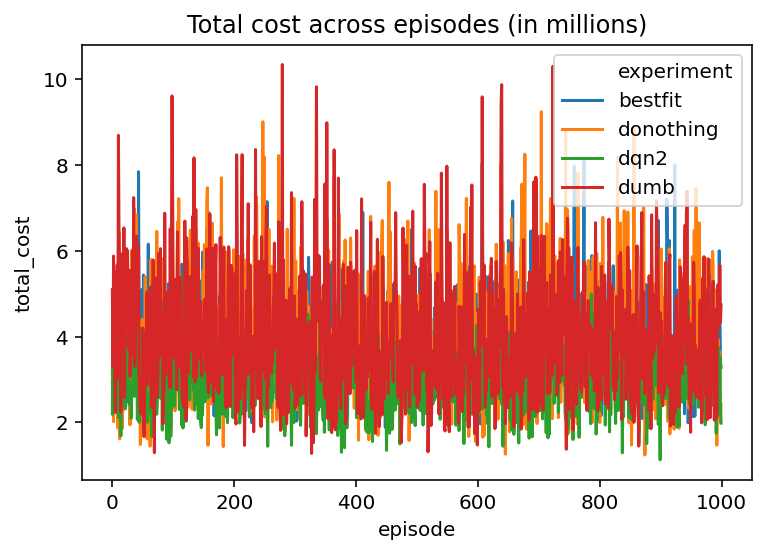

In [62]:

sns.lineplot(x='episode',y='total_cost',hue='experiment',data=cpe).set_title("Total cost across episodes (in millions)")

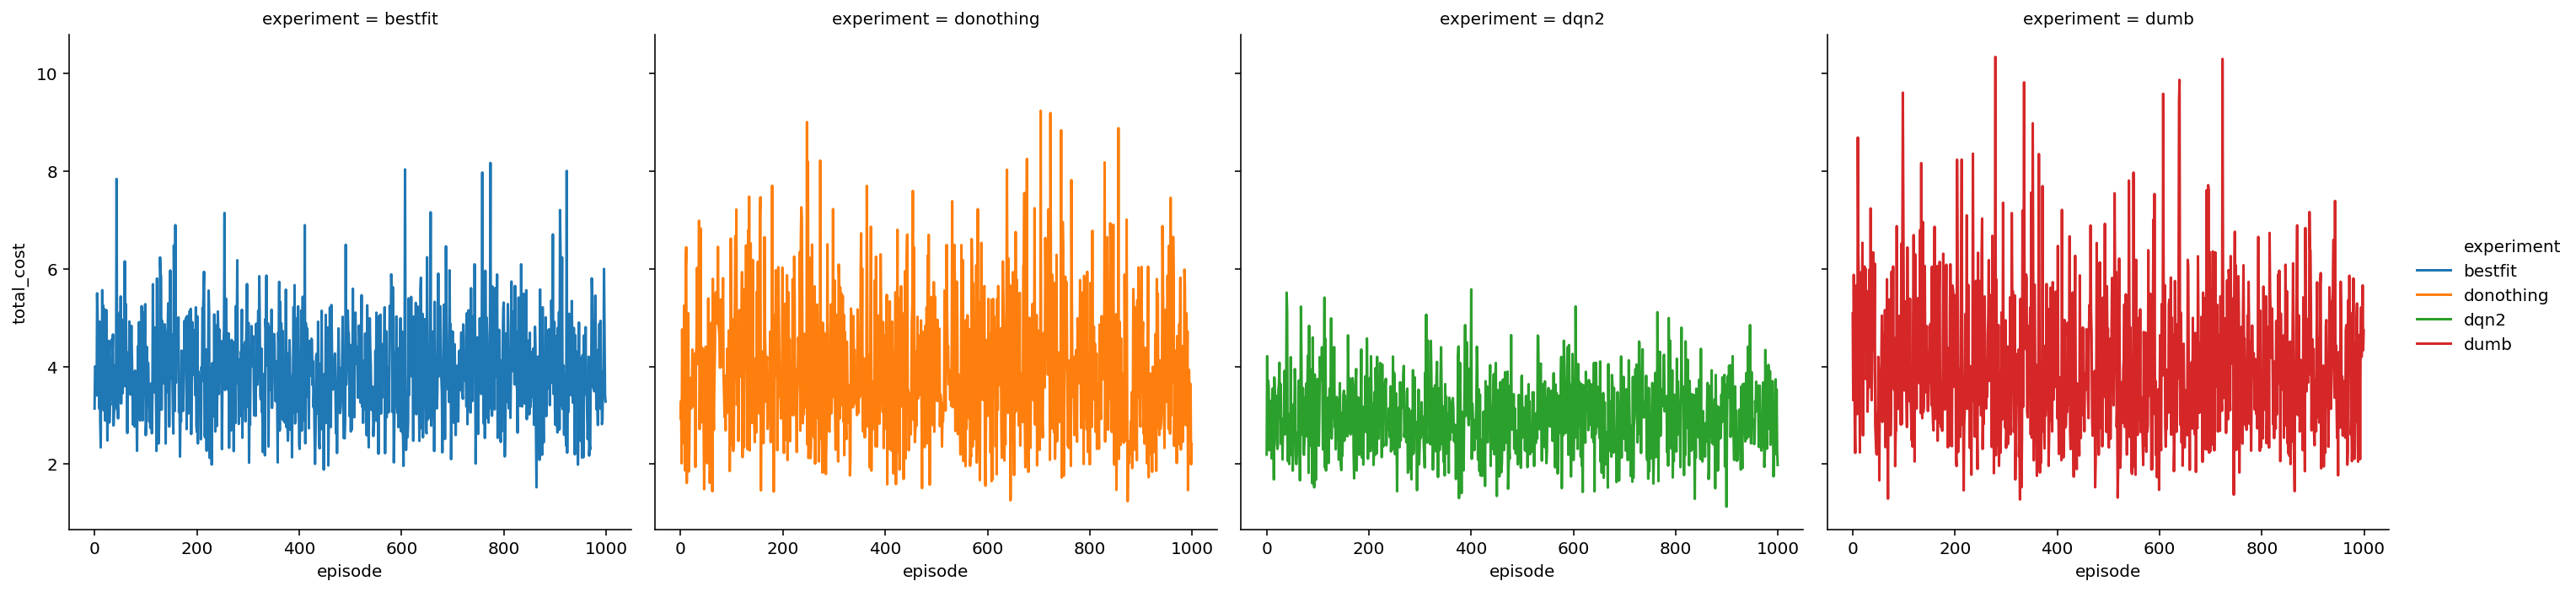

In [151]:
#g = sns.FacetGrid(cpe, col="experiment")
#g = g.map(lambda d: sns.lineplot(x='episode',y='total_cost',data=d))
#sns.lineplot(x='episode',y='total_cost',data=cpe).set_title("Total cost across episodes (in millions)")
sns.relplot(x="episode", y="total_cost",hue='experiment',col='experiment',data=cpe,kind='line')

# 2 - Is there a significant change in STD?
There is a significant improvement in average cost per episode and in std.

In [74]:
cpe.groupby('experiment')['total_cost'].describe().sort_values('std')

,count,mean,std,min,25%,50%,75%,max
experiment,,,,,,,,
dqn2,1000.0,2.962701,0.728721,1.124895,2.434249,2.921938,3.450770,5.581606
bestfit,1000.0,3.896705,0.995585,1.523361,3.169481,3.789014,4.544901,8.171681
donothing,1000.0,3.934491,1.416721,1.238355,2.867362,3.715551,4.835029,9.240672
dumb,1000.0,4.022143,1.458914,1.273221,2.925399,3.755124,4.971634,10.343954


# 3 - Are the results comparable/replicable?

In [94]:
dqn2_actions_ep_100 = pd.read_csv("data/results/dqn2_few_warehouses_v3/ep_100/movement_detail_report.csv")
bestfit_actions_ep_100 = pd.read_csv("data/results/bestfit_few_warehouses_v3/ep_100/movement_detail_report.csv")
display("Compare total units for each customer")
all_summaries.query('episode==100').groupby('experiment')['customer_units'].sum().reset_index()

display("Compare # of orders")
pd.concat([dqn2_actions_ep_100.query("movement_type=='Delivery'").groupby('destination_name').size().reset_index().sort_values(0,ascending=False).head(15),
bestfit_actions_ep_100.query("movement_type=='Delivery'").groupby('destination_name').size().reset_index().sort_values(0,ascending=False).head(15)],axis=1)



'Compare total units for each customer'

,experiment,customer_units
0,bestfit,9211840
1,donothing,9211840
2,dqn2,9211840
3,dumb,9211840


'Compare # of orders'

,destination_name,0,destination_name,0
62,c_9,25,c_9,25
41,c_66,25,c_66,25
53,c_8,20,c_8,20
9,c_22,20,c_22,20
65,c_92,15,c_92,15
26,c_48,15,c_48,15
67,c_94,15,c_94,15
7,c_19,15,c_19,15
61,c_88,15,c_88,15
56,c_83,15,c_83,15


# 4 - How much assigned DCs vary per customer?
At ep 0? 500? 1000?

In [149]:
dqn2_actions_ep_999 = pd.read_csv("data/results/dqn2_few_warehouses_v3/ep_999/movement_detail_report.csv")
dqn2_actions_ep_999['is_m']=  dqn2_actions_ep_999.customer_cost == dqn2_actions_ep_999.customer_units*big_m*10
actions_per_customer = dqn2_actions_ep_999.query('movement_type=="Delivery"').groupby(['destination_name','source_name','is_m']).aggregate('size').reset_index().sort_values('destination_name')
print("Top customers by number of distinct sources")
actions_per_customer.groupby(['destination_name','is_m'])['source_name'].nunique().reset_index().sort_values('source_name',ascending=False)

print("Top customers by number of distinct sources based on M")
print("No Ms were assigned in the last episode")
actions_per_customer.groupby(['destination_name','is_m'])['source_name'].nunique().reset_index().sort_values('source_name',ascending=False).query('is_m')

Top customers by number of distinct sources


,destination_name,is_m,source_name
0,c_100,False,1
49,c_66,False,1
56,c_75,False,1
55,c_74,False,1
54,c_73,False,1
...,...,...,...
25,c_37,False,1
24,c_36,False,1
23,c_35,False,1
22,c_34,False,1


Top customers by number of distinct sources based on M
No Ms were assigned in the last episode


,destination_name,is_m,source_name


# 5 - Zoom in on an episode with a really large discrepancy

In [108]:
bestfit_cpe = cpe.query('experiment== "bestfit"')
dqn2_cpe = cpe.query('experiment== "dqn2"')

compare = bestfit_cpe[['episode','total_cost']].rename(columns={'total_cost':'bestfit_cost'}).merge(dqn2_cpe[['episode','total_cost']].rename(columns={'total_cost':'dqn2_cost'}))
compare['dqn_win_amount']= compare.bestfit_cost - compare.dqn2_cost

compare.sort_values('dqn_win_amount',ascending=False)

,episode,bestfit_cost,dqn2_cost,dqn_win_amount
43,43,7.844246,2.240989,5.603257
923,923,8.008256,2.438483,5.569773
758,758,7.974944,2.713331,5.261614
657,657,7.160631,1.977952,5.182679
607,607,8.038725,2.967635,5.071090
...,...,...,...,...
39,39,3.124027,5.513934,-2.389907
83,83,2.270159,4.832905,-2.562745
945,945,1.987117,4.848458,-2.861340
400,400,2.375328,5.581606,-3.206278


In [126]:
dqn2_actions_ep_42 = pd.read_csv("data/results/dqn2_few_warehouses_v3/ep_42/movement_detail_report.csv")
bestfit_actions_ep_42 = pd.read_csv("data/results/bestfit_few_warehouses_v3/ep_42/movement_detail_report.csv")

big_m = 100000
dqn2_actions_ep_42['is_m'] = dqn2_actions_ep_42.customer_cost == dqn2_actions_ep_42.customer_units*big_m*10
bestfit_actions_ep_42['is_m'] = bestfit_actions_ep_42.customer_cost == bestfit_actions_ep_42.customer_units*big_m*10

# how many big ms
print("Comparing big M DQN vs Bestfit")
dqn2_actions_ep_42.groupby('is_m').size()
bestfit_actions_ep_42.groupby('is_m').size()

print("Comparing costs")
dqn2_actions_ep_42.sum().reset_index().merge(bestfit_actions_ep_42.sum().reset_index(),on='index').rename(columns={"0_x":'dqn',"0_y":'bestfit'})


Comparing big M DQN vs Bestfit


is_m
False    650
True      79
dtype: int64

is_m
False    650
True      90
dtype: int64

Comparing costs


,index,dqn,bestfit
0,source_name,dcs_0dcs_1dcs_2dcs_0dcs_1dcs_0dcs_1dcs_0dcs_1d...,dcs_1dcs_2dcs_1dcs_2dcs_2dcs_2dcs_2dcs_2dcs_1d...
1,destination_name,dcs_2dcs_2dcs_0dcs_2dcs_2dcs_2dcs_2dcs_2dcs_2d...,dcs_0dcs_0dcs_0dcs_0dcs_0dcs_0dcs_0dcs_1dcs_0c...
2,source_time,12691,12938
3,destination_time,12691,12938
4,source_kind,DCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDC...,DCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDCDC...
5,destination_kind,DCDCDCDCDCDCDCDCDCDCCCCCCDCCCCCCCCCCCCCCCCCCCC...,DCDCDCDCDCDCDCDCDCCCCCCCCCCCCCCCCCCCCCCCCCCDCC...
6,movement_type,TransportationTransportationTransportationTran...,TransportationTransportationTransportationTran...
7,transportation_units,5899538,4981409
8,transportation_cost,58995380,49814090
9,inventory_units,0,0


# conclusions
DQN is correctly learning *something*. Looks like DQN wins because DQN is selecting fewer Big Ms. 
 Two questions: 
- Why are both agents assigning Big Ms? It shouldn't be necessary. 
- If assigning big ms is a bug on bestfit, could DQN be better? Seems not.

New ideas to test: 
- See if bigms in bestfit can be avoided
- Compare again. If they are similar (what I expect), test with a bigger network.
- Implement dates?
- Persiste the physical network and allowed DCs per customer to explore better.

# Debug: does do nothing have bigMs?
Do nothing still has Big Ms, so something should be wrong (Do nothing chooses from the set of valid DCs of a customer)

In [155]:
donothing_actions_ep_42 = pd.read_csv("data/results/donotrhing_few_warehouses_v3/ep_42/movement_detail_report.csv")
donothing_actions_ep_42['is_m'] = donothing_actions_ep_42.customer_cost == donothing_actions_ep_42.customer_units*big_m*10

donothing_actions_ep_42.groupby('is_m').size()

is_m
False    650
True      69
dtype: int64